# Spherical attention equivariance test

Tests rotational equivariance of spherical attention modules. The core idea: applying attention then rotating should match rotating then applying attention.

Method:
1. Rotate input signals using SO(3) transformations
2. Apply attention module
3. Rotate output back
4. Compare with direct attention application

Interpolation error provides a baseline for numerical accuracy of the rotation procedure.

## Setup

In [ ]:
import torch
import torch.nn as nn
import torch_harmonics as th
import numpy as np
from scipy.interpolate import RegularGridInterpolator, SmoothSphereBivariateSpline


from torch_harmonics import AttentionS2
from torch_harmonics.quadrature import precompute_latitudes
from torch_harmonics.plotting import plot_sphere

## Configuration

Grid type and device selection for the tests.


In [2]:
# grid = "legendre-gauss"
grid="equiangular"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Helper functions

Rotation and interpolation utilities for testing equivariance on the sphere:
- `rotate_grid`: applies SO(3) YZY Euler rotations to spherical coordinates
- `interpolate_to_grid`: performs cubic interpolation between grids
- `equivariance_test_signal`: main test function that rotates, applies attention, and computes error metrics


In [ ]:
def cartesian_to_spherical(x, y, z):
    """Convert from cartesian to spherical coordinates (theta, phi). phi in [0, 2pi)"""
    theta = np.arccos(z)
    phi = (np.arctan2(y, x) + 2*np.pi) % (2*np.pi)
    return theta, phi

def rotate_grid(theta_grid, phi_grid, alpha, beta, gamma):
    """Apply SO(3) YZY rotation to a lat/lon grid."""
    # Convert to cartesian
    x = np.sin(theta_grid) * np.cos(phi_grid)
    y = np.sin(theta_grid) * np.sin(phi_grid)
    z = np.cos(theta_grid)
    # Stack and flatten
    coords = np.stack([x.flatten(), y.flatten(), z.flatten()])
    # Rotation matrix for YZY (passive rotation)
    # This is a placeholder, you might use scipy.spatial.transform.Rotation if needed
    from scipy.spatial.transform import Rotation as R
    rot = R.from_euler('yzy', [gamma, beta, alpha])
    rotated = rot.apply(coords.T)
    # Convert back to spherical
    x_rot, y_rot, z_rot = rotated[:,0], rotated[:,1], rotated[:,2]
    theta_rot, phi_rot = cartesian_to_spherical(x_rot, y_rot, z_rot)
    theta_rot = theta_rot.reshape(theta_grid.shape)
    phi_rot = phi_rot.reshape(phi_grid.shape)
    return theta_rot, phi_rot

def interpolate_to_grid(signal, theta_to, phi_to, method="cubic"):
    """Interpolate signal defined on (theta_from, phi_from) to (theta_to, phi_to)."""
    orig_shape = signal.shape
    # cylindrical extension to handle boundary
    signal = torch.cat([signal, signal[..., 0:1]], dim=-1)
    phi_from = np.linspace(0, 2 * np.pi, signal.shape[-1])
    theta_from = np.linspace(0, np.pi, signal.shape[-2])
    signal = signal.reshape(-1, *signal.shape[-2:]).movedim(0, -1)
    # Assume signal: [batch, nlat, nlon], theta_from, phi_from: [nlat, nlon]
    interpolator = RegularGridInterpolator(
        (theta_from, phi_from),
        signal.cpu().detach().numpy(),
        method=method,
        bounds_error=True,
        fill_value=0.
    )
    interp_points = np.stack([theta_to.flatten(), phi_to.flatten()], axis=-1)
    signal_interp = interpolator(interp_points)
    return torch.tensor(signal_interp, dtype=signal.dtype, device=signal.device).movedim(-1, 0).reshape(orig_shape)

In [4]:
def equivariance_test_signal(q, k, v, attention_module, theta, phi, alpha, beta, gamma, quadrature_weights):
    """Test equivariance by rotating, running attention, rotating back, and comparing."""
    # 1. Rotate input grid
    theta_r, phi_r = rotate_grid(theta, phi, alpha, beta, gamma)
    # 2. Interpolate signal to rotated grid
    q_rot = interpolate_to_grid(q, theta_r, phi_r)
    k_rot = interpolate_to_grid(k, theta_r, phi_r)
    v_rot = interpolate_to_grid(v, theta_r, phi_r)
    # 3. Apply attention module
    out_rot = attention_module(q_rot, k_rot, v_rot)
    # 4. Undo rotation: rotate grid by SO(3) inverse, interpolate back
    theta_inv, phi_inv = rotate_grid(theta, phi, -gamma, -beta, -alpha)
    out_rot_back = interpolate_to_grid(out_rot, theta_inv, phi_inv)
    # 5. Reference: apply attention module to signal directly
    out_ref = attention_module(q, k, v)
    # 6. Compute equivariance error: weighted L2 norm over the sphere
    equiv_error = ((out_rot_back - out_ref) ** 2 * quadrature_weights).sum(dim=(-1, -2)).sqrt() / (out_ref ** 2 * quadrature_weights).sum(dim=(-1, -2)).sqrt()
    # 7. Compute reference by computing interpolation error in the rotation
    out_rotrot = interpolate_to_grid(interpolate_to_grid(out_ref, theta_r, phi_r), theta_inv, phi_inv)
    interp_error = ((out_rotrot - out_ref) ** 2 * quadrature_weights).sum(dim=(-1, -2)).sqrt() / (out_ref ** 2 * quadrature_weights).sum(dim=(-1, -2)).sqrt()
    return equiv_error, interp_error

## Visualization test

Quick visual check of the rotation and interpolation pipeline. Generates a spherical harmonic signal, rotates it, and rotates it back to verify the procedure works correctly.


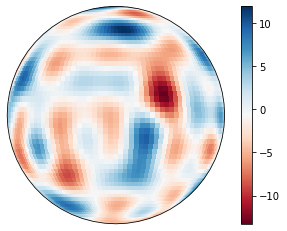

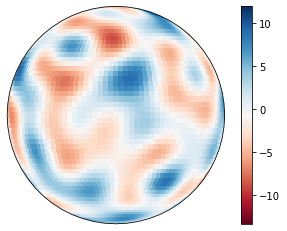

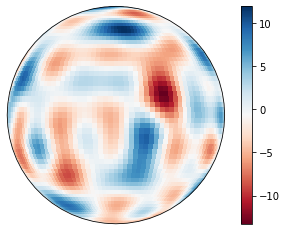

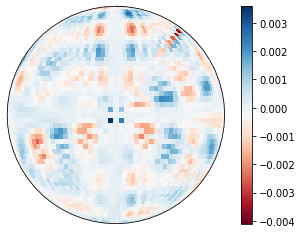

In [5]:
nlat = 65
nlon = 2*(nlat-1)

# sh coefficients
l_degree = 12
m_degree = 12

# input signal is a spherical harmonic
isht = th.InverseRealSHT(nlat, nlon, lmax=l_degree+1, mmax=m_degree+1)
# signal = torch.zeros(l_degree+1, m_degree+1, dtype=torch.complex64)
# signal[l_degree, m_degree] = 1.0
# signal = isht(signal)
signal = torch.randn(l_degree+1, m_degree+1, dtype=torch.complex64)
signal = isht(signal)

# do the rotated signal

# Define grid (equiangular example)
theta = np.linspace(0, np.pi, nlat)
phi = np.linspace(0, 2 * np.pi, nlon, endpoint=False)
theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

# Example: some SO(3) rotation
alpha, beta, gamma = 0.0, np.pi/5, np.pi/2

# passively rotate the grid and interpolate
theta_r, phi_r = rotate_grid(theta_grid, phi_grid, -gamma, -beta, -alpha)
signal_rot = interpolate_to_grid(signal, theta_r, phi_r)

# passively rotate the grid back and interpolate
theta_rr, phi_rr = rotate_grid(theta_grid, phi_grid, alpha, beta, gamma)
signal_rotrot = interpolate_to_grid(signal_rot, theta_rr, phi_rr)

plot_sphere(signal, projection="orthographic", central_longitude=180, colorbar=True)
plot_sphere(signal_rot, projection="orthographic", central_longitude=180, colorbar=True)
plot_sphere(signal_rotrot, projection="orthographic", central_longitude=180, colorbar=True)
plot_sphere(signal_rotrot - signal, projection="orthographic", central_longitude=180, colorbar=True)

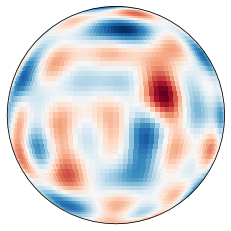

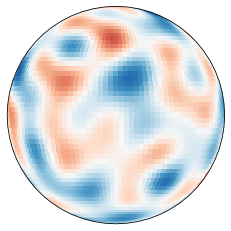

In [6]:
channels = out_channels = 1
k_channels = 3

attention_module = th.AttentionS2(channels, 1, (nlat, nlon), (nlat, nlon), grid_in=grid, grid_out=grid, k_channels=k_channels, out_channels=out_channels)

signal = attention_module(signal.unsqueeze(0).unsqueeze(0)).squeeze()
signal_rot = attention_module(signal_rot.unsqueeze(0).unsqueeze(0)).squeeze()

plot_sphere(signal.detach(), projection="orthographic", central_longitude=180)
plot_sphere(signal_rot.detach(), projection="orthographic", central_longitude=180)

## Equivariance test: identical query, key, value

Tests `AttentionS2` with the same input for query, key, and value across multiple grid resolutions. Measures how equivariance error scales with grid refinement. Lower resolutions have higher interpolation artifacts.

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

in_channels = out_channels = 1
k_channels = 1

# sh coefficients
l_degree = 12
m_degree = 12

q_weights = nn.Parameter(torch.randn(k_channels, in_channels, 1, 1, device=device))
k_weights = nn.Parameter(torch.randn(k_channels, in_channels, 1, 1,  device=device))
v_weights = nn.Parameter(torch.randn(out_channels, in_channels, 1, 1,  device=device))
proj_weights = nn.Parameter(torch.randn(out_channels, out_channels, 1, 1,  device=device))

nlats = 2**np.arange(3,8) + 1


coeffs = torch.randn(1, in_channels, l_degree+1, m_degree+1, dtype=torch.complex64)

print(f"nlats={nlats}")

for nlat in nlats:

    nlon = 2*(nlat-1)

    # Define grid (equiangular example)
    theta = np.linspace(0, np.pi, nlat)
    phi = np.linspace(0, 2 * np.pi, nlon, endpoint=False)
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

    # Assume quadrature weights are given or use Gaussian quadrature as done in torch-harmonics for accuracy
    # quadrature_weights = np.ones((nlat, nlon)) * (4*np.pi) / (nlat*nlon) # Placeholder
    _, quad_weights = precompute_latitudes(nlat, grid=grid)
    quad_weights = 2 * np.pi * quad_weights.reshape(-1, 1) / nlon

    # input signal is a spherical harmonic
    isht = th.InverseRealSHT(nlat, nlon, lmax=l_degree+1, mmax=m_degree+1)
    # signal = torch.zeros(l_degree+1, m_degree+1, dtype=torch.complex64)
    # signal[l_degree, m_degree] = 1.0
    # signal = isht(signal).to(device)
    signal = isht(coeffs).to(device)

    # Example: some SO(3) rotation
    # alpha, beta, gamma = 0, np.pi/5, 0
    alpha, beta, gamma = np.pi/3, np.pi/5, np.pi/2

    # Define your torch-harmonics spherical attention module
    attention_module = th.AttentionS2(in_channels, 1, (nlat, nlon), (nlat, nlon), grid_in=grid, grid_out=grid, k_channels=k_channels, out_channels=out_channels).to(device)
    # attention_module = th.NeighborhoodAttentionS2(in_channels, (nlat, nlon), (nlat, nlon), grid_in=grid, grid_out=grid, k_channels=k_channels, out_channels=out_channels, theta_cutoff=0.25 * np.pi, optimized_kernel=True).to(device)
    attention_module.q_weights = q_weights
    attention_module.k_weights = k_weights
    attention_module.v_weights = v_weights
    attention_module.proj_weights = proj_weights

    equiv_error, interp_error = equivariance_test_signal(
        signal, signal, signal, attention_module,
        theta_grid, phi_grid,
        alpha, beta, gamma,
        torch.tensor(quad_weights, device=device)
    )
    print(f"grid: {nlat}x{nlon}")
    print(f"Interpolation error: {interp_error.item()}")
    print(f"Equivariance error: {equiv_error.item()}")

nlats=[  9  17  33  65 129]


/tmp/ipykernel_1257088/2649942724.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(quad_weights, device=device)


grid: 9x16
Interpolation error: 0.5110252370430134
Equivariance error: 0.5601505570923117
grid: 17x32
Interpolation error: 0.11014389466099073
Equivariance error: 0.12903838070355614
grid: 33x64
Interpolation error: 0.021498938891502326
Equivariance error: 0.02332751149567875
grid: 65x128
Interpolation error: 0.002848767523334506
Equivariance error: 0.003295258864837139
grid: 129x256
Interpolation error: 0.00026699662450192546
Equivariance error: 0.00021689470616254402


## Equivariance test: distinct query, key, value

Tests `NeighborhoodAttentionS2` with different inputs for query, key, and value. Runs on a batch of random spherical harmonic signals to compute statistical measures (mean and standard deviation) of equivariance error across multiple samples.

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

batch_size = 32

in_channels = out_channels = 1
k_channels = 1

# sh coefficients
l_degree = 12
m_degree = 12

q_weights = nn.Parameter(torch.ones(k_channels, in_channels, 1, 1, device=device))
k_weights = nn.Parameter(torch.ones(k_channels, in_channels, 1, 1,  device=device))
v_weights = nn.Parameter(torch.ones(out_channels, in_channels, 1, 1,  device=device))
proj_weights = nn.Parameter(torch.ones(out_channels, out_channels, 1, 1,  device=device))

nlats = 3 * 2**np.arange(2,8) + 1

coeffs_q = torch.randn(batch_size, in_channels, l_degree+1, m_degree+1, dtype=torch.complex64)
coeffs_k = torch.randn(batch_size, in_channels, l_degree+1, m_degree+1, dtype=torch.complex64)
coeffs_v = torch.randn(batch_size, in_channels, l_degree+1, m_degree+1, dtype=torch.complex64)

print(f"nlats={nlats}")

for nlat in nlats:

    nlon = 2*(nlat-1)

    # Define grid (equiangular example)
    theta = np.linspace(0, np.pi, nlat)
    phi = np.linspace(0, 2 * np.pi, nlon, endpoint=False)
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')

    # Assume quadrature weights are given or use Gaussian quadrature as done in torch-harmonics for accuracy
    # quadrature_weights = np.ones((nlat, nlon)) * (4*np.pi) / (nlat*nlon) # Placeholder
    _, quad_weights = precompute_latitudes(nlat, grid=grid)
    quad_weights = 2 * np.pi * quad_weights.reshape(-1, 1) / nlon

    # input signal is a spherical harmonic
    isht = th.InverseRealSHT(nlat, nlon, lmax=l_degree+1, mmax=m_degree+1)
    # signal = torch.zeros(l_degree+1, m_degree+1, dtype=torch.complex64)
    # signal[l_degree, m_degree] = 1.0
    # signal = isht(signal).to(device)
    q = isht(coeffs_q).to(device)
    k = isht(coeffs_k).to(device)
    v = isht(coeffs_v).to(device)

    # Example: some SO(3) rotation
    # alpha, beta, gamma = 0, np.pi/5, 0
    alpha, beta, gamma = np.pi/3, np.pi/5, np.pi/2

    # Define your torch-harmonics spherical attention module
    # attention_module = th.AttentionS2(in_channels, 1, (nlat, nlon), (nlat, nlon), grid_in=grid, grid_out=grid, k_channels=k_channels, out_channels=out_channels).to(device)
    attention_module = th.NeighborhoodAttentionS2(in_channels, (nlat, nlon), (nlat, nlon), grid_in=grid, grid_out=grid, k_channels=k_channels, out_channels=out_channels, theta_cutoff=0.25 * np.pi, optimized_kernel=True).to(device)
    attention_module.q_weights = q_weights
    attention_module.k_weights = k_weights
    attention_module.v_weights = v_weights
    attention_module.proj_weights = proj_weights

    interp_errors = []
    equiv_errors = []

    with torch.no_grad():
        for i in range(batch_size):
            equiv_error, interp_error = equivariance_test_signal(
                q[i:i+1], k[i:i+1], v[i:i+1], attention_module,
                theta_grid, phi_grid,
                alpha, beta, gamma,
                torch.tensor(quad_weights, device=device)
            )
            equiv_errors.append(equiv_error.sum().item())
            interp_errors.append(interp_error.sum().item())


    print(f"grid: {nlat}x{nlon}")
    std, mean = torch.std_mean(torch.Tensor(interp_errors))
    print(f"Interpolation error mean: {mean.item()} std: {std.item()}")
    std, mean = torch.std_mean(torch.Tensor(equiv_errors))
    print(f"Equivariance error mean: {mean.item()} std: {std.item()}")

nlats=[ 13  25  49  97 193 385]


/tmp/ipykernel_1257088/3891120704.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(quad_weights, device=device)
/tmp/ipykernel_1257088/3891120704.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(quad_weights, device=device)


grid: 13x24
Interpolation error mean: 0.3600526750087738 std: 0.04040982946753502
Equivariance error mean: 0.8799694776535034 std: 0.11993429809808731
grid: 25x48
Interpolation error mean: 0.2122473269701004 std: 0.01835968717932701
Equivariance error mean: 0.5413421988487244 std: 0.06379222124814987
grid: 49x96
Interpolation error mean: 0.10668758302927017 std: 0.010952126234769821
Equivariance error mean: 0.2220321148633957 std: 0.0300905779004097
grid: 97x192
Interpolation error mean: 0.04530394822359085 std: 0.006954884622246027
Equivariance error mean: 0.08676204085350037 std: 0.014798644930124283
grid: 193x384
Interpolation error mean: 0.01467582955956459 std: 0.0033174711279571056
Equivariance error mean: 0.028914814814925194 std: 0.00572592718526721
grid: 385x768
Interpolation error mean: 0.0028963687364012003 std: 0.0008681176695972681
Equivariance error mean: 0.008655384182929993 std: 0.0019559646025300026
